In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format

from perturbseq import *

# Loading a population

This loads the dataset from Fig. 3 of:

Adamson, B.A., Norman, T.M., *et al.* "A multiplexed CRISPR screening platform enables systematic dissection of the unfolded protein response", *Cell*, 2016.

Briefly, this experiment contained cells in which all combinatorial knockdowns (i.e., single, double, and triple) were made of the three branches of the unfolded protein response (UPR) using CRISPRi. These cells were then subjected to chemical treatments: DMSO (control), tunicamycin, and thapsigargin. The latter two are potent inducers of the UPR.

The sequencing data can be downloaded from:

https://www.dropbox.com/s/22yi75rw21bsvdg/perturb_seq_demo_sequencing.zip?dl=0

and should be unzipped in the folder containing the notebook so that a subdirectory `sequencing` is created.

In [2]:
pop = CellPopulation.from_file('./sequencing/10X005_new/',
                               genome='hg19')

Loading digital expression data: ./sequencing/10X005_new/outs/filtered_gene_bc_matrices/hg19/matrix.mtx...
Densifying matrix...
Loading guide identities:./sequencing/10X005_new/outs/cell_identities.csv...
Generating summary statistics...
Done.


**Remove multiplets... this follows the query syntax that will be outlined below.**

In [3]:
pop = pop.subpopulation(cells='single_cell')

Generating summary statistics...
Done.


# Metadata

**All populations are associated with two metadata dataframes that are organized according to the following diagram:**

```
             |------------------------------|
             |                              |
             |        GENE METADATA         |
             |          pop.genes           |
             |                              |
             |------------------------------|

|-----------||------------------------------|
|           ||                              |
|           ||                              |
|   CELL    ||                              |
|   META    ||                              |
|   DATA    ||          EXPRESSION          |
| pop.cells ||          pop.matrix          |
|           ||                              |
|           ||                              |
|           ||                              |
|           ||                              |
|           ||                              |
|-----------||------------------------------|
```

**The metadata can be used to slice or subselect expression data as we will see below** 

In [4]:
pop.cells.head()

,guide_identity,guide_read_count,guide_UMI_count,guide_coverage,good_coverage,number_of_cells,guide_target,single_cell,UMI_count,gem_group
cell_barcode,,,,,,,,,,
AAACATACACTCAG-1,3x_neg_ctrl_pMJ144-1,261.0000,59.0000,4.4237,True,1.0000,3x,True,24343,1
AAACATACTCCTAT-1,3x_neg_ctrl_pMJ144-2,132.0000,37.0000,3.5676,True,1.0000,3x,True,27678,1
AAACATTGCAGAGG-1,3x_neg_ctrl_pMJ144-2,560.0000,117.0000,4.7863,True,1.0000,3x,True,24745,1
AAACATTGGCGAAG-1,ATF6_PERK_IRE1_pMJ158,215.0000,49.0000,4.3878,True,1.0000,ATF6,True,30836,1
AAACCGTGATACCG-1,ATF6_PERK_pMJ150,567.0000,124.0000,4.5726,True,1.0000,ATF6,True,33314,1


In [5]:
pop.genes.head()

,gene_name,mean,std,cv,fano,in_matrix
gene_id,,,,,,
ENSG00000243485,MIR1302-10,0.0001,0.0122,82.1371,0.9999,True
ENSG00000237613,FAM138A,0.0000,0.0000,nan,nan,True
ENSG00000186092,OR4F5,0.0000,0.0000,nan,nan,True
ENSG00000238009,RP11-34P13.7,0.0001,0.0086,116.1637,1.0000,True
ENSG00000239945,RP11-34P13.8,0.0001,0.0122,82.1371,0.9999,True


**Add some useful metadata specific to this experiment**

In [6]:
perturbations = ['ATF6_only_pMJ145', 'PERK_only_pMJ146',  'IRE1_only_pMJ148', 'ATF6_PERK_pMJ150', 'PERK_IRE1_pMJ154', 'ATF6_IRE1_pMJ152', 'ATF6_PERK_IRE1_pMJ158']
controls = ['3x_neg_ctrl_pMJ144-1', '3x_neg_ctrl_pMJ144-2']

guide_renamer = {'3x_neg_ctrl_pMJ144-1': 'control',
                 '3x_neg_ctrl_pMJ144-2': 'control',
                 'ATF6_only_pMJ145': 'ATF6',
                 'PERK_only_pMJ146': 'PERK',
                 'IRE1_only_pMJ148': 'IRE1',
                 'ATF6_PERK_pMJ150': 'ATF6-PERK',
                 'PERK_IRE1_pMJ154': 'IRE1-PERK',
                 'ATF6_IRE1_pMJ152': 'ATF6-IRE1',
                 'ATF6_PERK_IRE1_pMJ158': 'ATF6-IRE1-PERK'}

guide_targeter = {'3x_neg_ctrl_pMJ144-1': [],
                 '3x_neg_ctrl_pMJ144-2': [],
                 'ATF6_only_pMJ145': ['ATF6'],
                 'PERK_only_pMJ146': ['EIF2AK3'],
                 'IRE1_only_pMJ148': ['ERN1'],
                 'ATF6_PERK_pMJ150': ['ATF6', 'EIF2AK3'],
                 'PERK_IRE1_pMJ154': ['ERN1', 'EIF2AK3'],
                 'ATF6_IRE1_pMJ152': ['ATF6', 'ERN1'],
                 'ATF6_PERK_IRE1_pMJ158': ['ATF6', 'EIF2AK3', 'ERN1']}

sample_renamer = {1: 'Tm',
                 2: 'Thaps',
                 3: 'DMSO'}

In [7]:
experiment = pop.cells['gem_group'].map(lambda x: sample_renamer[x])
experiment.name = 'experiment'
perturbation = pop.cells['guide_identity'].map(lambda x: guide_renamer[x])
perturbation.name = 'perturbation'
long_experiment = experiment + '_' + perturbation
long_experiment.name = 'long_experiment'

**Method below is slightly smarter than just using pandas, and will for example replace columns with the same names with the new information.** 

In [8]:
pop.add_property(cells=pd.DataFrame([experiment, perturbation, long_experiment]).T)

# Slicing populations using `pop.where`

**The metadata can be used in subselections of either cells or genes. These queries should in fact work in any method I have written that has a `cells` or `genes` keyword argument, as they all internally all call `pop.where`.  Here is an example subselecting on properties defined in the metadata:**

In [9]:
pop.where(cells='experiment == "Thaps"',
          genes='mean > 5').head()

gene_id,ENSG00000175756,ENSG00000242485,ENSG00000160075,ENSG00000116288,ENSG00000074800,ENSG00000116649,ENSG00000173436,ENSG00000142676,ENSG00000117632,ENSG00000142684,...,ENSG00000160256,ENSG00000198888,ENSG00000198763,ENSG00000198804,ENSG00000198712,ENSG00000198899,ENSG00000198938,ENSG00000198886,ENSG00000198786,ENSG00000198727
cell_barcode,,,,,,,,,,,,,,,,,,,,,
AAACATACACACTG-2,0,0,0,6,5,1,4,43,1,1,...,0,10,12,69,44,6,28,32,3,24
AAACATACCCGATA-2,14,5,8,13,28,16,4,87,10,9,...,2,72,68,238,234,58,131,160,14,62
AAACATACCTTGCC-2,29,9,3,24,49,21,5,162,14,12,...,10,62,67,219,149,48,129,119,8,49
AAACATACGACACT-2,30,10,3,21,32,18,4,177,15,5,...,6,94,83,347,343,91,211,248,16,119
AAACATACGAGGAC-2,17,6,3,34,34,22,5,145,17,7,...,4,71,45,266,171,56,95,137,12,66


**Lists can also be passed**

In [10]:
noisy_gene_ids = pop.genes.query('mean > 2 and cv > 1').index

In [11]:
pop.where(cells='experiment == "Thaps"',
          genes=noisy_gene_ids).head()

gene_id,ENSG00000142669,ENSG00000117399,ENSG00000143333,ENSG00000117724,ENSG00000034510,ENSG00000134057,ENSG00000180573,ENSG00000137193,ENSG00000186480,ENSG00000102265,...,ENSG00000170312,ENSG00000168209,ENSG00000175197,ENSG00000102804,ENSG00000051108,ENSG00000101255,ENSG00000160888,ENSG00000130513,ENSG00000128228,ENSG00000100097
cell_barcode,,,,,,,,,,,,,,,,,,,,,
AAACATACACACTG-2,0,0,0,0,7,0,1,0,2,2,...,0,0,2,0,1,1,0,0,71,2
AAACATACCCGATA-2,6,1,4,0,6,0,11,4,3,0,...,2,12,27,3,32,17,3,3,396,2
AAACATACCTTGCC-2,7,5,1,0,28,10,4,5,2,5,...,2,4,2,2,9,1,2,2,106,5
AAACATACGACACT-2,1,1,3,0,8,0,13,6,3,3,...,0,2,22,3,10,7,2,3,273,5
AAACATACGAGGAC-2,1,0,1,4,5,1,5,0,1,4,...,0,1,1,1,1,2,3,0,38,1


**By default genes are identified by Ensembl ids, but if you pass gene names or use the `gene_names=True` flag results will be returned with human-readable names.**

In [12]:
pop.where(cells='experiment == "Thaps"',
          genes=noisy_gene_ids,
          gene_names=True).head()

,SH3BGRL3,CDC20,RGS16,CENPF,TMSB10,CCNB1,HIST1H2AC,PIM1,INSIG1,TIMP1,...,CDK1,DDIT4,DDIT3,TSC22D1,HERPUD1,TRIB3,IER2,GDF15,SDF2L1,LGALS1
cell_barcode,,,,,,,,,,,,,,,,,,,,,
AAACATACACACTG-2,0,0,0,0,7,0,1,0,2,2,...,0,0,2,0,1,1,0,0,71,2
AAACATACCCGATA-2,6,1,4,0,6,0,11,4,3,0,...,2,12,27,3,32,17,3,3,396,2
AAACATACCTTGCC-2,7,5,1,0,28,10,4,5,2,5,...,2,4,2,2,9,1,2,2,106,5
AAACATACGACACT-2,1,1,3,0,8,0,13,6,3,3,...,0,2,22,3,10,7,2,3,273,5
AAACATACGAGGAC-2,1,0,1,4,5,1,5,0,1,4,...,0,1,1,1,1,2,3,0,38,1


In [13]:
pop.where(cells='experiment == "Thaps"',
          genes=['DDIT3', 'ATF4', 'RPL7']).head()

,RPL7,DDIT3,ATF4
cell_barcode,,,
AAACATACACACTG-2,14,2,0
AAACATACCCGATA-2,54,27,7
AAACATACCTTGCC-2,71,2,9
AAACATACGACACT-2,93,22,9
AAACATACGAGGAC-2,80,1,1


**You can switch back and forth using the `pop.gene_ids` and `pop.gene_names` methods.**

In [14]:
pop.gene_ids(['DDIT3', 'ATF4', 'RPL7'])

array(['ENSG00000175197', 'ENSG00000128272', 'ENSG00000147604'],
      dtype=object)

In [15]:
pop.gene_names(['ENSG00000175197', 'ENSG00000128272', 'ENSG00000147604'])

array(['DDIT3', 'ATF4', 'RPL7'], dtype=object)

# Memory efficiency

**For memory efficiency, remove genes with no counts from expression matrix.**

In [16]:
pop.info()

Matrix
<class 'pandas.core.frame.DataFrame'>
Index: 13494 entries, AAACATACACTCAG-1 to TTTGCATGTATCTC-3
Columns: 32738 entries, ENSG00000243485 to ENSG00000215611
dtypes: int32(32738)
memory usage: 1.6 GB


In [17]:
strip_low_expression(pop) 

In [18]:
pop.info()

Matrix
<class 'pandas.core.frame.DataFrame'>
Index: 13494 entries, AAACATACACTCAG-1 to TTTGCATGTATCTC-3
Columns: 19833 entries, ENSG00000243485 to ENSG00000215699
dtypes: int32(19833)
memory usage: 1022.3 MB


**You can use experimental sparse matrix support, but computations may be quite slow. Also note that the default z-normalization discussed below can't be sparsified that much since it isn't 0-inflated.**

In [19]:
pop.sparsify_matrix()

Sparsifying matrix...


In [20]:
pop.info()

Matrix
<class 'pandas.core.sparse.frame.SparseDataFrame'>
Index: 13494 entries, AAACATACACTCAG-1 to TTTGCATGTATCTC-3
Columns: 19833 entries, ENSG00000243485 to ENSG00000215699
dtypes: int32(19833)
memory usage: 218.4 MB


In [21]:
pop.densify_matrix()

Densifying matrix...


**Save as hdf5 so that we don't have to do slow steps every time notebook runs. If the population includes a normalized matrix (discussed below), set `store_normalized_matrix=True` (or regenerate it on the fly)**

In [22]:
pop.to_hdf('pop.hdf')

Writing matrix...
Writing metadata...
Done in 7.07895994186s.


/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2878: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['good_coverage', 'guide_identity', 'guide_target', 'experiment', 'perturbation', 'long_experiment']]

  exec(code_obj, self.user_global_ns, self.user_ns)


In [23]:
del pop

In [24]:
pop = CellPopulation.from_hdf('pop.hdf')

Loading matrix...
Loading metadata...
Done in 1.57170701027s.
Done.


In [25]:
pop.info()

Matrix
<class 'pandas.core.frame.DataFrame'>
Index: 13494 entries, AAACATACACTCAG-1 to TTTGCATGTATCTC-3
Columns: 19833 entries, ENSG00000243485 to ENSG00000215699
dtypes: int32(19833)
memory usage: 1021.7 MB


# Subpopulations and cell cycle calling

**Subpopulations can be extracted according to conditions.  As background, this experiment consists of 8 genetic backgrounds (all single, double, and triple knockdowns of the 3 UPR branches) observed across 3 conditions (+DMSO, +thapsigargin, and +tunicamycin).**

**A query can then be used to pull out only control cells exposed to DMSO**

In [26]:
control_pop = pop.subpopulation(cells='long_experiment == "DMSO_control"')

Generating summary statistics...
Done.


**Can then use my (somewhat janky) cell-cycle phase calling. I take a curated list of cell cycle genes and look for those that are coherent within an unperturbed cell population.**

In [27]:
cell_cycle_genes = get_cell_phase_genes(control_pop, refine=True, threshold=0.3)

add_cell_cycle_scores(pop, gene_list=cell_cycle_genes)
add_cell_cycle_scores(control_pop, gene_list=cell_cycle_genes)

perturbseq/cell_cycle.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  expression_matrix['total'] = expression_matrix.mean(axis=1)


**Next we might want to look explicitly at cells under a particular condition. Below we create a subpopulation containing of all of these samples, together with DMSO-treated control cells.**

**Note I have to explicitly pass the list as an additional argument below. Queries to `pop.where` (which is used behind the scenes here) have access to any additional keyword arguments that have been passed along.**

In [28]:
thaps_experiments = ['DMSO_control', 'Thaps_control', 'Thaps_ATF6-IRE1', 
                     'Thaps_ATF6-PERK', 'Thaps_IRE1-PERK', 'Thaps_ATF6-IRE1-PERK',
                     'Thaps_ATF6', 'Thaps_IRE1', 'Thaps_PERK']

In [29]:
thaps_pop = pop.subpopulation(cells='long_experiment in @thaps_experiments',
                             thaps_experiments=thaps_experiments)

Generating summary statistics...
Done.


# Normalizing gene expression

**Each CellPopulation in fact has two expression DataFrames -- `pop.matrix`, which contains the raw UMI counts, and `pop.normalized_matrix` which can contain some normalized form of expression. The package includes methods for log_2 normalization and z-normalization (potentially relative to a control population).**

**Here we will z-normalize expression relative to a defined subset. In this case we are effectively saying that we'd like to score gene expression relative to DMSO-treated control cells, so that we can examine the differences in genes induced by thapsigargin treatment across the different genetic backgrounds.**

In [30]:
thaps_pop.normalized_matrix = normalize_to_control(thaps_pop,
                                                   'long_experiment == "DMSO_control"')

     Determining scale factors...
     Normalizing matrix to median
     Normalizing control matrix to median
     Scaling matrix to control
     Done.


**In multi-lane Perturb-seq experiments the recommendation is to include a large number of unperturbed control cells in each lane/gemgroup. By z-normalizing expression relative to these cells, lane-to-lane batch variability is removed.**

In [31]:
# command that would be used for a larger multi-gemgroup 10x experiment where control cells 
# in each lane are marked by having property "perturbation" set to "control" 

#pop.normalized_matrix = normalize_to_gemgroup_control(pop,
#                                                      control_cells='perturbation == "control"')

# Average populations

**Generate a mean population by a key in the metadata. This will average all the cells together for each unique value in the chosen key. The "cells" of the resulting mean population will then correspond to each key.**

In [32]:
mean_pop = pop.average('long_experiment',
                       show_progress=True)

Computing average expression matrices...


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


Computing clusters...


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


Generating summary statistics...
Done.


**Can also average cells in a subpopulation defined by a query. E.g. this averages only over cells in the DMSO condition.**

In [33]:
DMSO_experiments = ['DMSO_control', 'DMSO_ATF6-IRE1', 'DMSO_ATF6-PERK',
                    'DMSO_IRE1-PERK', 'DMSO_ATF6-IRE1-PERK',
                    'DMSO_ATF6', 'DMSO_IRE1', 'DMSO_PERK']

In [34]:
DMSO_mean_pop = pop.average('long_experiment',
                             cells='long_experiment in @thaps_experiments',
                             show_progress=True,
                             thaps_experiments=thaps_experiments)

Computing average expression matrices...


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

groupby: index in @key_barcodes and (long_experiment in @thaps_experiments) (key = long_experiment)

Computing clusters...


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

groupby: index in @key_barcodes and (long_experiment in @thaps_experiments) (key = long_experiment)

Generating summary statistics...
Done.


**Finally, let's average our thapsigargin-treated population**

In [35]:
thaps_mean_pop = thaps_pop.average('long_experiment',
                                   show_progress=True)

Computing average expression matrices...


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


Computing normalized average expression matrices...


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


Computing clusters...


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


Generating summary statistics...
Done.


**All the same methods work here as on a single-cell population.**

In [36]:
thaps_mean_pop.where(genes=noisy_gene_ids,
              gene_names=True,
              normalized=True).head()

,SH3BGRL3,CDC20,RGS16,CENPF,TMSB10,CCNB1,HIST1H2AC,PIM1,INSIG1,TIMP1,...,CDK1,DDIT4,DDIT3,TSC22D1,HERPUD1,TRIB3,IER2,GDF15,SDF2L1,LGALS1
DMSO_control,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,...,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000
Thaps_ATF6,-0.1391,-0.0491,2.4527,-0.3391,-0.2937,-0.4020,1.5795,1.1158,0.4511,-0.1027,...,-0.0503,4.0198,3.4772,0.3843,4.1018,4.3590,-0.0571,0.2397,3.5926,-0.0845
Thaps_ATF6-IRE1,-0.1615,-0.1083,2.1765,-0.3316,-0.2596,-0.3513,1.2006,1.1857,0.4862,-0.0615,...,0.0303,3.8735,2.9305,0.4490,2.3646,4.7877,-0.0883,0.2430,1.6412,-0.1574
Thaps_ATF6-IRE1-PERK,-0.1012,-0.0683,0.0957,-0.0024,-0.1615,-0.0307,0.1277,0.2349,1.1848,-0.0428,...,0.0051,0.5742,0.2038,-0.0582,0.4895,0.3765,-0.1179,0.0041,1.1294,-0.0146
Thaps_ATF6-PERK,-0.0788,-0.0192,0.3644,-0.1599,-0.1356,-0.0191,0.1493,0.2283,1.0269,-0.0737,...,-0.0198,0.5311,0.4018,0.0593,1.4511,0.4852,-0.2143,-0.0179,2.9920,-0.0393


**Mean populations also have some additional methods for showing data from across the different conditions.**

In [37]:
thaps_mean_pop.expression(noisy_gene_ids)

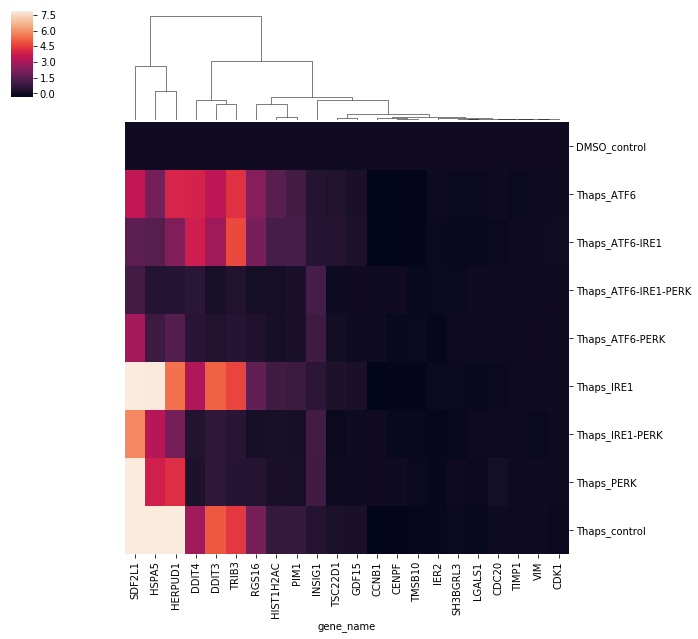

In [38]:
thaps_mean_pop.expression_heatmap(noisy_gene_ids, normalized=True, robust=True)

# Differential expression

**There are a number of ways to look for differentially regulated genes. A simple heuristic is based on deviations from the mean-CV relationship.**

493 variable genes found (0 excluded)


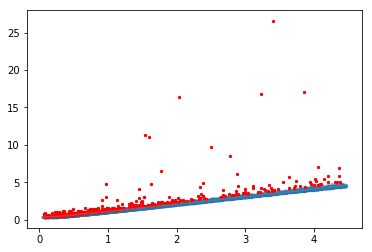

In [39]:
noisy_genes = find_noisy_genes(thaps_pop)

In [40]:
thaps_mean_pop.where(genes=noisy_genes, gene_names=True)

,HES4,AGRN,ACTL8,ID3,SH3BGRL3,CD52,SESN2,SNHG12,LAPTM5,ZBTB8A,...,MAFF,ATF4,GTSE1,CRELD2,SAMSN1,TMEM50B,MT-CO2,MT-ATP6,MT-ND3,MT-ND4
DMSO_control,0.7080,0.1405,0.0779,0.0988,5.5104,0.1756,0.3063,0.5642,4.9517,0.0933,...,0.1131,5.2053,0.9791,1.4391,2.0252,0.9726,206.7179,75.9319,2.9682,153.3677
Thaps_ATF6,0.7603,0.0825,0.0629,0.0275,4.5796,0.0864,2.1336,3.0413,4.7485,0.3143,...,0.1218,8.4519,0.5403,2.4185,3.7210,1.6562,177.8566,59.4637,1.9843,138.5462
Thaps_ATF6-IRE1,0.8027,0.0794,0.0658,0.0612,4.2449,0.1315,2.1995,2.7710,4.6735,0.2132,...,0.1179,8.0544,0.5193,2.1542,3.3810,1.5420,171.7619,57.1859,1.9093,133.4490
Thaps_ATF6-IRE1-PERK,0.6473,0.1483,0.0762,0.0341,4.5711,0.0902,0.4008,0.6092,5.2625,0.1002,...,0.1443,6.8136,0.8116,1.9659,1.9379,1.4148,177.8938,62.2164,1.9800,127.5351
Thaps_ATF6-PERK,0.5768,0.1074,0.0842,0.0358,4.4989,0.1305,0.4484,0.6905,5.0295,0.1074,...,0.1347,6.8126,0.8063,2.2021,2.0800,1.2905,173.6253,61.2547,2.2758,126.0989
Thaps_IRE1,0.8136,0.0951,0.1010,0.0408,4.6621,0.1165,2.0757,2.3650,4.3689,0.2117,...,0.1165,8.3767,0.6369,4.1184,2.9650,3.6194,188.9282,61.8680,1.8874,142.4718
Thaps_IRE1-PERK,0.5798,0.1342,0.0759,0.0467,4.2665,0.1167,0.4805,0.5545,4.5136,0.1031,...,0.0837,6.5545,0.9397,2.9533,1.8346,2.8911,181.2354,62.6070,2.1907,128.0642
Thaps_PERK,0.4915,0.1047,0.0620,0.0406,5.0150,0.1111,0.4615,0.5641,4.6987,0.1816,...,0.0769,6.5897,0.8504,4.0235,1.9359,2.7201,171.6410,59.4444,2.2030,123.0556
Thaps_control,0.5878,0.0828,0.0739,0.0509,4.4681,0.0938,2.0958,2.1916,4.1148,0.2984,...,0.1118,8.7375,0.6148,5.4521,2.9770,3.4411,182.1048,60.3094,1.9082,138.4641


**Simple differential expression based on KS test. Here you again define a key that is used to define each subpopulation that is being tested. The `control_cells` argument is a separate query that defines the control subpopulation. You can define a method for FDR control from `statsmodels.stats.multitest`.**

In [41]:
ks, ps, adj_ps = ks_de(thaps_pop,
                       key='long_experiment',
                       control_cells='long_experiment == "DMSO_control"',
                       genes='mean > 0.25',
                       normalized=True,
                       alpha=0.001,
                       multi_method='fdr_by',
                       n_jobs=16)

911 control cells
groupby: index in @key_barcodes (key = long_experiment)


[Parallel(n_jobs=16)]: Done   2 out of   9 | elapsed:    3.8s remaining:   13.4s
[Parallel(n_jobs=16)]: Done   3 out of   9 | elapsed:    4.0s remaining:    8.1s
[Parallel(n_jobs=16)]: Done   4 out of   9 | elapsed:    4.2s remaining:    5.3s
[Parallel(n_jobs=16)]: Done   5 out of   9 | elapsed:    4.3s remaining:    3.5s
[Parallel(n_jobs=16)]: Done   6 out of   9 | elapsed:    4.6s remaining:    2.3s
[Parallel(n_jobs=16)]: Done   7 out of   9 | elapsed:    4.6s remaining:    1.3s
[Parallel(n_jobs=16)]: Done   9 out of   9 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done   9 out of   9 | elapsed:    5.2s finished


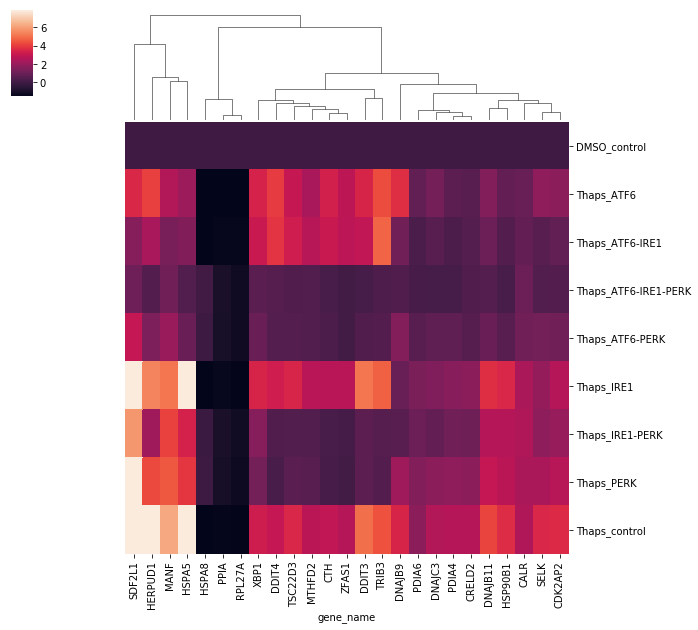

In [42]:
thaps_mean_pop.expression_heatmap(genes=adj_ps.min(axis=1).sort_values().head(25).index,
                                  normalized=True,
                                  robust=True)

**Finally there are the random forest-based methods, which use either a classifier or the Boruta algorithm to identify, respectively, a desired number of highly variable genes or all of the genes that vary across conditions.**

In [43]:
res = tree_selector(thaps_pop,
                    key='long_experiment',
                    num_features=100,
                    genes='mean > 0.25',
                    normalized=True,
                    n_jobs=16)

Training (genes: mean > 0.25)...
Using 1134 estimators for 6436 features...
Feature prediction accuracy (test size: 20.0%): 0.491096532334

                      precision    recall  f1-score   support

        DMSO_control       0.46      0.99      0.63       182
          Thaps_ATF6       0.67      0.06      0.11       102
     Thaps_ATF6-IRE1       0.90      0.41      0.56        88
Thaps_ATF6-IRE1-PERK       0.00      0.00      0.00       100
     Thaps_ATF6-PERK       0.87      0.14      0.24        95
          Thaps_IRE1       0.00      0.00      0.00       103
     Thaps_IRE1-PERK       0.69      0.33      0.45       103
          Thaps_PERK       0.73      0.61      0.66        94
       Thaps_control       0.41      0.99      0.58       200

           micro avg       0.49      0.49      0.49      1067
           macro avg       0.53      0.39      0.36      1067
        weighted avg       0.50      0.49      0.39      1067



/home/tmn/.local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Picked 100 features.
Using 141 estimators for 100 features...
Feature prediction accuracy (test size: 20.0%): 0.815370196813

                      precision    recall  f1-score   support

        DMSO_control       0.91      0.97      0.94       182
          Thaps_ATF6       0.79      0.83      0.81       102
     Thaps_ATF6-IRE1       0.80      0.72      0.75        88
Thaps_ATF6-IRE1-PERK       0.83      0.76      0.79       100
     Thaps_ATF6-PERK       0.83      0.68      0.75        95
          Thaps_IRE1       0.83      0.70      0.76       103
     Thaps_IRE1-PERK       0.80      0.76      0.78       103
          Thaps_PERK       0.74      0.74      0.74        94
       Thaps_control       0.77      0.92      0.84       200

           micro avg       0.82      0.82      0.82      1067
           macro avg       0.81      0.79      0.80      1067
        weighted avg       0.82      0.82      0.81      1067



**The overall prediction accuracy is a simple metric that lets you gauge how well-separated the populations are. In this case we can distinguish the different genetic backgrounds quite well.**

In [44]:
tree_genes = res.selected_genes

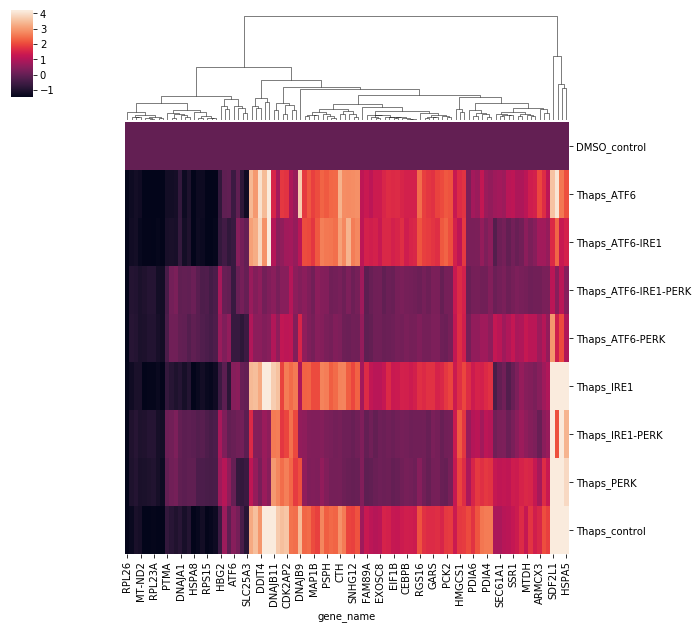

In [45]:
thaps_mean_pop.expression_heatmap(genes=tree_genes,
                                  normalized=True,
                                  robust=True)

In [46]:
thaps_mean_pop.expression(tree_genes)

**Look at correlated expression**

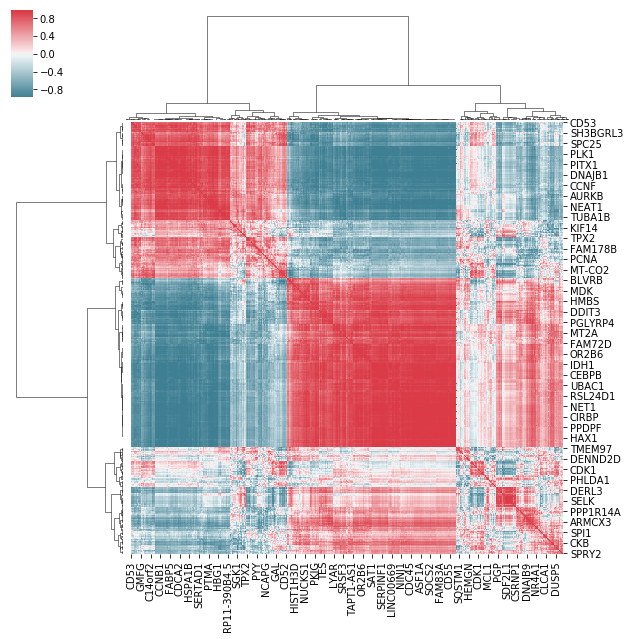

In [47]:
correlation_heatmap(thaps_mean_pop, noisy_genes, normalized=True)

**We can also of course manipulate the expression data directly with any pandas/seaborn/sklearn methods. E.g. let's look at the correlation matrix among our genetic conditions**

In [48]:
import seaborn as sns

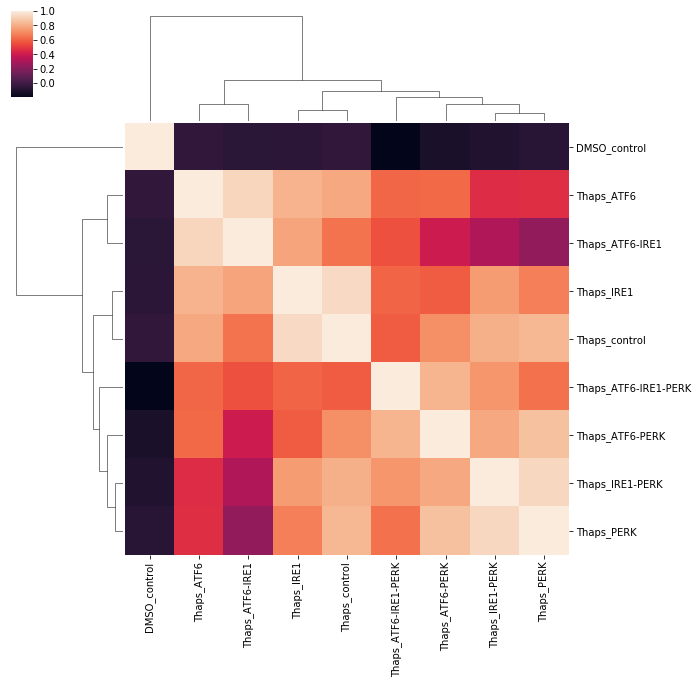

In [49]:
sns.clustermap(thaps_mean_pop.where(genes=tree_genes, normalized=True).T.corr())

# Transformers and plotting

**Populations have `fit` and `fit_transform` methods that takes any expression query, produces the table, applies any scikit-learn object's `fit` or `fit_transform` method, and beautifies the result. For example, I've included a transformer for dimensionality reduction with PCA + tSNE projection. You can look in `transformers.py` for more.**

In [50]:
transformer = PCATSNEReducer(n_components=8,
                            use_sklearn=True,
                            verbose=True)

In [51]:
reduced = thaps_pop.fit_transform(transformer,
                                  genes=tree_genes,
                                  normalized=True)

Performing PCA...
Performing TSNE...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5334 samples in 0.031s...
[t-SNE] Computed neighbors for 5334 samples in 0.283s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5334
[t-SNE] Computed conditional probabilities for sample 2000 / 5334
[t-SNE] Computed conditional probabilities for sample 3000 / 5334
[t-SNE] Computed conditional probabilities for sample 4000 / 5334
[t-SNE] Computed conditional probabilities for sample 5000 / 5334
[t-SNE] Computed conditional probabilities for sample 5334 / 5334
[t-SNE] Mean sigma: 1.356828
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.633736
[t-SNE] KL divergence after 1000 iterations: 1.585440
Done.


In [52]:
reduced.head(10)

,TSNE0,TSNE1
cell_barcode,,
AAACATACACACTG-2,64.1958,-21.7705
AAACATACCCGATA-2,14.7358,-77.1399
AAACATACCTTGCC-2,25.9629,4.1606
AAACATACGACACT-2,-3.5148,-28.2528
AAACATACGAGGAC-2,1.6944,47.1353
AAACCGTGCCTGAA-2,4.0833,-81.5965
AAACCGTGGAAACA-2,10.1771,-75.5485
AAACCGTGGCGTTA-2,-16.9922,-55.9050
AAACCGTGGTGAGG-2,47.3544,6.4133


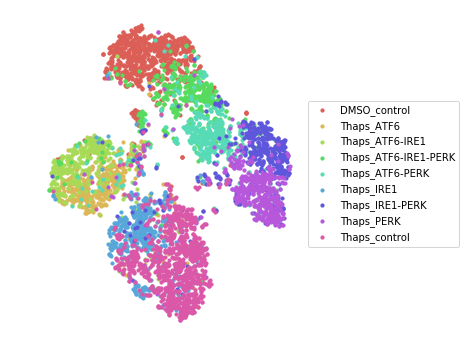

In [53]:
plt.figure(figsize=[6,6])
thaps_pop.plot(reduced, 'long_experiment')

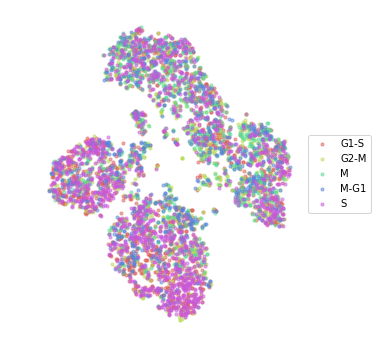

In [54]:
plt.figure(figsize=[6,6])
thaps_pop.plot(reduced, 'cell_cycle_phase', alpha=0.5)

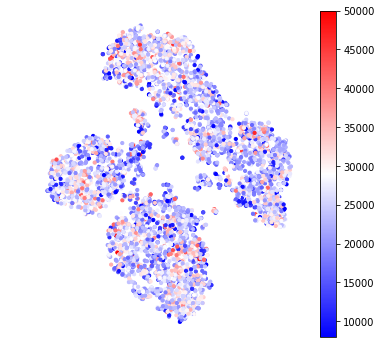

In [55]:
plt.figure(figsize=[6,6])
thaps_pop.plot(reduced, traits='UMI_count')
plt.clim([8000, 50000])

**The random forest identifies the genes that are best at classifying cells into the different populations. If we look at some that have been assigned high importances we might expect them to be subpopulation-specific.**

In [56]:
thaps_mean_pop.expression(pop.gene_ids(res.importances.head(5).index))

**E.g. the induction of these genes seems to be quite ATF6-dependent. We can plot their expression alongside the genetic backgrounds using `plots`.**

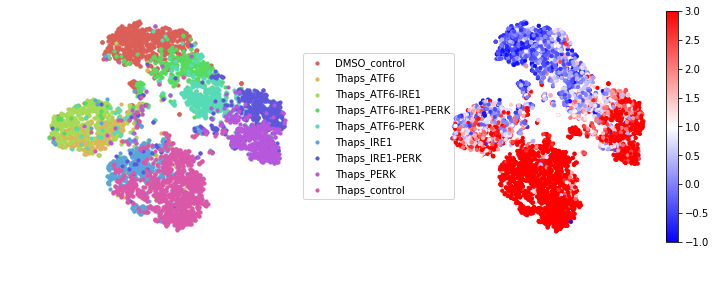

In [57]:
plt.figure(figsize=[10,4])
thaps_pop.plots(reduced, ['long_experiment', 'HSPA5'], types=['discrete', 'gene'], normalized=True)
plt.clim([-1, 3])

**As noted, any sklearn model can be used. E.g. let's make a UMAP projection instead.**

In [58]:
from umap import UMAP

In [59]:
umap_reduced = thaps_pop.fit_transform(UMAP(n_neighbors=10, metric='correlation'),
                                      genes=tree_genes,
                                      normalized=True)

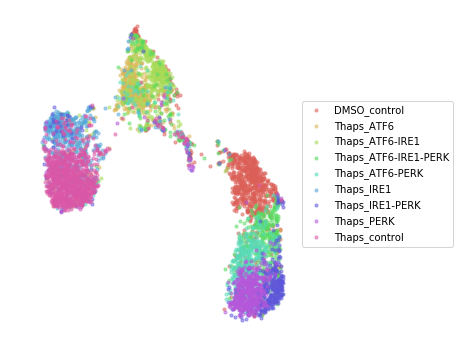

In [60]:
plt.figure(figsize=[6,6])
thaps_pop.plot(umap_reduced, 'long_experiment', alpha=0.5)